In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim import lr_scheduler
import copy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path="/content/drive/MyDrive/vision lab/alexnet,vgg16,resnet,inception_v1/vgg_scratch/data/train/"
test_path="/content/drive/MyDrive/vision lab/alexnet,vgg16,resnet,inception_v1/vgg_scratch/data/validation/"

In [ ]:
device= "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
data_transform={
     
      "train": transforms.Compose([
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()
    ]),

      "test": transforms.Compose([
                                 transforms.RandomSizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()
    ]),
}

In [ ]:
image_data={
    
    "train": torchvision.datasets.ImageFolder(train_path,transform=data_transform["train"]),
    "val" :  torchvision.datasets.ImageFolder(test_path,transform=data_transform["test"])
}

In [ ]:
image_data_loader={
    "train": torch.utils.data.DataLoader(image_data["train"],batch_size=32,num_workers=4),
    "val" : torch.utils.data.DataLoader(image_data["val"],batch_size=32,num_workers=4)
}

In [ ]:
for x,y in image_data_loader["train"]:
  print(x.size())
  print(x.size(0))
  break

torch.Size([32, 3, 224, 224])
32


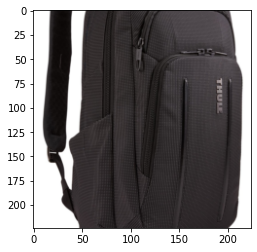

In [ ]:
plt.imshow(image_data["train"][1][0].permute(1,2,0))

In [ ]:
data_sizes = {
    "train": len(image_data["train"]),
    "val": len(image_data["val"])
}
data_sizes

{'train': 484, 'val': 264}

In [ ]:
class_names = image_data["train"].classes
class_names

['backpack', 'footwear', 'glasses', 'watch']

In [ ]:
model_conv = torchvision.models.vgg16(pretrained=True)

print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model_conv.parameters():
  param.required_grad = False

In [ ]:
model_conv.classifier[6]=nn.Linear(in_features=4096,out_features=len(class_names),bias=True)
model_conv.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)

In [ ]:
model_conv = model_conv.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(model_conv.classifier[6].parameters(), lr=0.001)

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop(model, loss_fn, optimizer, scheduler, num_epochs=20):

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    print("=="*10)

    for phase in ["train", "val"]:
      training = phase == "train"
      if training:
        model.train() # sets the training mode
      else:
        model.eval() # sets the evaluation mode

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in image_data_loader[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(training):
          outputs = model(inputs)

          _, preds = torch.max(outputs, 1)
          loss = loss_fn(outputs, preds)

          if training:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if training:
        scheduler.step()

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase] # mod

      print(f"{phase}, Loss: {epoch_loss}, accuracy: {epoch_acc}")
      if not training and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  
  model.load_state_dict(best_model_wts)
  return model


        




In [ ]:
model = train_loop(model_conv, loss_fn, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
train, Loss: 0.16596656475189211, accuracy: 0.2603305785123967
val, Loss: 0.0005875151413916187, accuracy: 0.25
Epoch 1/19
train, Loss: 0.00010310363290015578, accuracy: 0.25
val, Loss: 0.000109625261040602, accuracy: 0.25
Epoch 2/19
train, Loss: 4.912142770810217e-05, accuracy: 0.25
val, Loss: 0.00011009086009642377, accuracy: 0.25
Epoch 3/19
train, Loss: 4.867975877452168e-05, accuracy: 0.25
val, Loss: 0.00011589958739932626, accuracy: 0.25
Epoch 4/19
train, Loss: 2.8794613311122306e-05, accuracy: 0.25
val, Loss: 0.00014209295871599656, accuracy: 0.25
Epoch 5/19
train, Loss: 3.6203439055144894e-05, accuracy: 0.25
val, Loss: 0.00012363352024377409, accuracy: 0.25
Epoch 6/19
train, Loss: 3.741661203845475e-05, accuracy: 0.25
val, Loss: 4.859369150698044e-05, accuracy: 0.25
Epoch 7/19
train, Loss: 1.757544948703086e-05, accuracy: 0.25
val, Loss: 9.424065082743199e-05, accuracy: 0.25
Epoch 8/19
train, Loss: 3.2349050426948585e-05, accuracy: 0.25
val, Loss: 0.000102171004927544

In [ ]:
path="/content/drive/MyDrive/vision lab/alexnet,vgg16,resnet,inception_v1/vgg_scratch/model.pkl"
torch.save(model.state_dict(),path)